# Automatic Hyperparameter Tuning / AutoML

> Also known as AutoML, Automatic Machine Learning, Meta-optimization, Meta-learning, and so on.

So not only you want to build neural networks and other machine learning algorithms, but also you want to find the best hyperparameters for them automatically. We'll here demonstrate how it's possible with Neuraxle. 

## AutoML loop

Neuraxle provides an AutoML step which can perform automatic tuning of the hyperparameters of any neuraxle-defined pipeline. It also provides multiple hyperparameter research strategies, interfaces to store and load results and a high degree of customisability. The following tutorial will provide an example of the main features of the AutoML step.

### Define your problem
For this tutorial, we'll use a synthetic binary classification dataset generated by sklearn with 10k samples.

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import shutil

n_classes = 2
classes = list(range(n_classes))

def generate_classification_data():
    data_inputs, expected_outputs = make_classification(
        n_samples=10000,
        n_informative=10,
        n_repeated=0,
        n_classes=n_classes,
        n_features=15,
        n_clusters_per_class=1,
        class_sep=1.0,
        flip_y=0,
        weights=[0.5, 0.5]
    )

    X_train, X_test, y_train, y_test = train_test_split(
        data_inputs,
        expected_outputs,
        test_size=0.20
    )
    
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = generate_classification_data()

### Define your pipeline

Consider a sklearn classifier with a defined hyperparameter space.

In [2]:
from neuraxle.base import BaseTransformer
from neuraxle.pipeline import Pipeline
from neuraxle.hyperparams.space import HyperparameterSpace
from neuraxle.steps.numpy import NumpyRavel
from neuraxle.steps.output_handlers import OutputTransformerWrapper
from typing import List

# sklearn classifiers, and sklearn wrapper for neuraxle 
from neuraxle.steps.sklearn import SKLearnWrapper
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier


# neuraxle distributions 
from neuraxle.hyperparams.distributions import Choice, RandInt, Boolean, LogUniform, FixedHyperparameter
    
classifier = SKLearnWrapper(SGDClassifier(), 
                   HyperparameterSpace({
                       'max_iter': FixedHyperparameter(1),
                       'learning_rate': FixedHyperparameter('constant'),
                       'loss': FixedHyperparameter('hinge'),#Choice(['hinge','log', 'modified_huber', 'squared_hinge']),
                       'penalty':Choice(['l2', 'l1', 'elasticnet']),
                       'alpha':LogUniform(1e-9, 1e-3),
                       'eta0': LogUniform(1e-6, 1e-3)
                   }),
                   use_partial_fit=True,
                   partial_fit_kwargs={'classes': classes})


Consider a pipeline which performs the following: shuffles the data on training and process incrementally the data in batch of 32 samples with the classifier.

In [3]:
from neuraxle.steps.flow import ChooseOneStepOf, TrainOnlyWrapper
from neuraxle.steps.data import DataShuffler
from neuraxle.pipeline import MiniBatchSequentialPipeline

p: Pipeline = Pipeline([
    TrainOnlyWrapper(DataShuffler()),
    MiniBatchSequentialPipeline([
        classifier
    ], batch_size=32,
    keep_incomplete_batch=True)
])

### Choose a validation splitter

Let's pick the [ValidationSplitter](https://www.neuraxle.org/stable/api/neuraxle.metaopt.auto_ml.html?highlight=validationsplitter#neuraxle.metaopt.auto_ml.ValidationSplitter) which is enough for most machine learning problems:

In [4]:
from neuraxle.metaopt.auto_ml import ValidationSplitter

validation_splitter = ValidationSplitter(test_size=0.20)

This validation splitter will perform a single 80%-20% split of the dataset.

We have also implemented [KFoldCrossValidationSplitter](https://www.neuraxle.org/stable/api/neuraxle.metaopt.auto_ml.html?highlight=kfoldcross#neuraxle.metaopt.auto_ml.KFoldCrossValidationSplitter) if you are interested in using cross-validation for your machine learning problem.

### Define a the main scoring metric with [ScoringCallback](https://www.neuraxle.org/stable/api/neuraxle.metaopt.callbacks.html?highlight=scoringcallback#neuraxle.metaopt.callbacks.ScoringCallback)

Let's pick the accuracy score as our scoring metric: 

In [5]:
from neuraxle.metaopt.callbacks import ScoringCallback
from sklearn.metrics import accuracy_score

scoring_callback = ScoringCallback(
    metric_function=accuracy_score, 
    name='accuracy', 
    higher_score_is_better=True,
    log_metrics=False
)

### Add other metric callbacks with [MetricCallback](https://www.neuraxle.org/stable/api/neuraxle.metaopt.callbacks.html?highlight=metriccallback#neuraxle.metaopt.callbacks.MetricCallback) (optional)

During training, we'll monitor the f1 score, the precision and the recall on the training and validation dataset. We will make use of the sklearn implementation of these metric, using a weighted average since we are in a multiclass setting.

In [6]:
from neuraxle.metaopt.callbacks import MetricCallback
from sklearn.metrics import f1_score, precision_score, recall_score

callbacks = [
    MetricCallback('f1', metric_function=f1_score, higher_score_is_better=True, log_metrics=False),
    MetricCallback('precision', metric_function=precision_score, higher_score_is_better=True, log_metrics=False),
    MetricCallback('recall', metric_function=recall_score, higher_score_is_better=True, log_metrics=False)
]

Multiple callbacks, such as EarlyStoppingCallback and SaveBestModelCallback are available as part of Neuraxle. You could also implement your own callback by inheriting from [BaseCallback](https://www.neuraxle.org/stable/api/neuraxle.metaopt.callbacks.html?highlight=basecallback#neuraxle.metaopt.callbacks.BaseCallback).

### Select an hyperparams repository 

For the sake of this example, let's pick the [InMemoryHyperparamsRepository](https://www.neuraxle.org/stable/api/neuraxle.metaopt.auto_ml.html?highlight=inmemoryhyperparamsrepository#neuraxle.metaopt.auto_ml.InMemoryHyperparamsRepository) because we don't need to persist trial files. [HyperparamsJSONRepository](https://www.neuraxle.org/stable/api/neuraxle.metaopt.auto_ml.html?highlight=hyperparamsjsonrepository#neuraxle.metaopt.auto_ml.HyperparamsJSONRepository)​ is also available if you want to use json files to persist trials.


In [7]:
from neuraxle.metaopt.auto_ml import InMemoryHyperparamsRepository

hyperparams_repository = InMemoryHyperparamsRepository(cache_folder='cache')

Neuraxle provides a subscriber-listener interface to perform plotting as trials are completed or on completion of the automl loop. A generic metric plotter is available, but creating a custom one for your needs is fairly straightforward.

In [8]:
from neuraxle.plotting import TrialMetricsPlottingObserver

hyperparams_repository.subscribe(TrialMetricsPlottingObserver(
    plotting_folder_name='metric_results', 
    save_plots=False, 
    plot_trial_on_next=False,
    plot_all_trials_on_complete=True,
    plot_individual_trials_on_complete=False
))

### Select an hyperparams optimizer 

We'll use the Tree Parzen Estimator algorithm as a research strategy.

In [9]:
from neuraxle.metaopt.tpe import TreeParzenEstimatorHyperparameterSelectionStrategy

hyperparams_optimizer = TreeParzenEstimatorHyperparameterSelectionStrategy(
    number_of_initial_random_step=5,
    quantile_threshold=0.3,
    number_good_trials_max_cap=25,
    number_possible_hyperparams_candidates=100,
    prior_weight=0.,
    use_linear_forgetting_weights=False,
    number_recent_trial_at_full_weights=25
)

Note: as of now, [TreeParzenEstimatorHyperparameterSelectionStrategy](https://www.neuraxle.org/stable/api/neuraxle.metaopt.tpe.html#neuraxle.metaopt.tpe.TreeParzenEstimatorHyperparameterSelectionStrategy) is the first usable Apache 2 public TPE implementation ! Thanks to Éric Hamel for implementing this amazing algorithm. 

Also note that if you don't define the hyperparams_optimizer argument, [RandomSearchHyperparameterSelectionStrategy](https://www.neuraxle.org/stable/api/neuraxle.metaopt.auto_ml.html?highlight=randomsearchhyperparam#neuraxle.metaopt.auto_ml.RandomSearchHyperparameterSelectionStrategy) will be used by default.

### Create, and launch AutoML loop

We are now ready to create the AutoML step that will execute the training loop:

In [10]:
from neuraxle.metaopt.auto_ml import AutoML
import os

tmpdir = 'cache'
if not os.path.exists(tmpdir):
    os.makedirs(tmpdir)
    
n_trials = 10
n_epochs = 10
    
auto_ml = AutoML(
    pipeline=p,
    validation_splitter=validation_splitter,
    refit_trial=True,
    n_trials=n_trials,
    epochs=n_epochs,
    cache_folder_when_no_handle=str(tmpdir),
    scoring_callback=scoring_callback,
    callbacks=callbacks,
    hyperparams_repository=hyperparams_repository
)

#### Run 10 trials 

[12:44:31][INFO][auto_ml][246]: 
new trial: {
    "MiniBatchSequentialPipeline": {
        "SKLearnWrapper_SGDClassifier": {
            "alpha": 2.486686368952862e-07,
            "eta0": 2.6464605881716034e-05,
            "learning_rate": "constant",
            "loss": "hinge",
            "max_iter": 1,
            "penalty": "elasticnet"
        }
    }
}
[12:44:31][INFO][auto_ml][862]: trial 1/10
[12:44:31][INFO][auto_ml][589]: fitting trial 1/10 split 1/1
hyperparams: {
    "MiniBatchSequentialPipeline": {
        "Joiner": {},
        "SKLearnWrapper_SGDClassifier": {
            "alpha": 2.486686368952862e-07,
            "average": false,
            "class_weight": null,
            "early_stopping": false,
            "epsilon": 0.1,
            "eta0": 2.6464605881716034e-05,
            "fit_intercept": true,
            "l1_ratio": 0.15,
            "learning_rate": "constant",
            "loss": "hinge",
            "max_iter": 1,
            "n_iter_no_change": 5,
  

[12:44:42][INFO][auto_ml][246]: 
new trial: {
    "MiniBatchSequentialPipeline": {
        "SKLearnWrapper_SGDClassifier": {
            "alpha": 2.2747983494317353e-06,
            "eta0": 3.044040225320792e-06,
            "learning_rate": "constant",
            "loss": "hinge",
            "max_iter": 1,
            "penalty": "l1"
        }
    }
}
[12:44:42][INFO][auto_ml][862]: trial 4/10
[12:44:42][INFO][auto_ml][589]: fitting trial 4/10 split 1/1
hyperparams: {
    "MiniBatchSequentialPipeline": {
        "Joiner": {},
        "SKLearnWrapper_SGDClassifier": {
            "alpha": 2.2747983494317353e-06,
            "average": false,
            "class_weight": null,
            "early_stopping": false,
            "epsilon": 0.1,
            "eta0": 3.044040225320792e-06,
            "fit_intercept": true,
            "l1_ratio": 0.15,
            "learning_rate": "constant",
            "loss": "hinge",
            "max_iter": 1,
            "n_iter_no_change": 5,
          

[12:44:52][INFO][auto_ml][246]: 
new trial: {
    "MiniBatchSequentialPipeline": {
        "SKLearnWrapper_SGDClassifier": {
            "alpha": 2.7048149801894626e-05,
            "eta0": 5.931390737593312e-06,
            "learning_rate": "constant",
            "loss": "hinge",
            "max_iter": 1,
            "penalty": "elasticnet"
        }
    }
}
[12:44:52][INFO][auto_ml][862]: trial 7/10
[12:44:52][INFO][auto_ml][589]: fitting trial 7/10 split 1/1
hyperparams: {
    "MiniBatchSequentialPipeline": {
        "Joiner": {},
        "SKLearnWrapper_SGDClassifier": {
            "alpha": 2.7048149801894626e-05,
            "average": false,
            "class_weight": null,
            "early_stopping": false,
            "epsilon": 0.1,
            "eta0": 5.931390737593312e-06,
            "fit_intercept": true,
            "l1_ratio": 0.15,
            "learning_rate": "constant",
            "loss": "hinge",
            "max_iter": 1,
            "n_iter_no_change": 5,
  

[12:45:02][INFO][auto_ml][246]: 
new trial: {
    "MiniBatchSequentialPipeline": {
        "SKLearnWrapper_SGDClassifier": {
            "alpha": 1.8668218610719405e-07,
            "eta0": 0.000714480097291864,
            "learning_rate": "constant",
            "loss": "hinge",
            "max_iter": 1,
            "penalty": "elasticnet"
        }
    }
}
[12:45:02][INFO][auto_ml][862]: trial 10/10
[12:45:02][INFO][auto_ml][589]: fitting trial 10/10 split 1/1
hyperparams: {
    "MiniBatchSequentialPipeline": {
        "Joiner": {},
        "SKLearnWrapper_SGDClassifier": {
            "alpha": 1.8668218610719405e-07,
            "average": false,
            "class_weight": null,
            "early_stopping": false,
            "epsilon": 0.1,
            "eta0": 0.000714480097291864,
            "fit_intercept": true,
            "l1_ratio": 0.15,
            "learning_rate": "constant",
            "loss": "hinge",
            "max_iter": 1,
            "n_iter_no_change": 5,
  

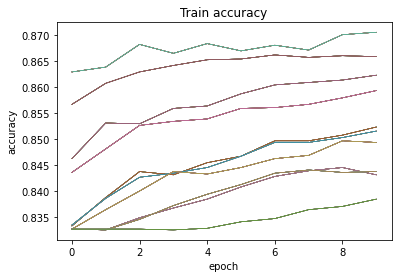

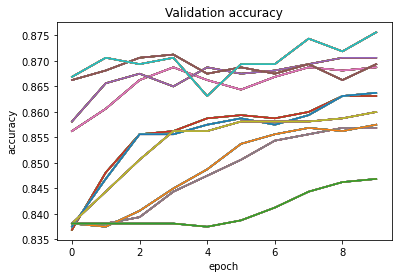

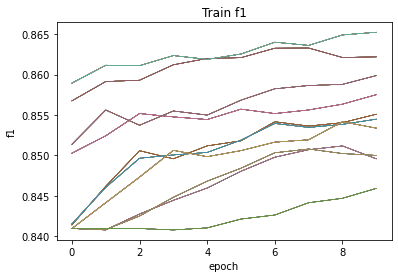

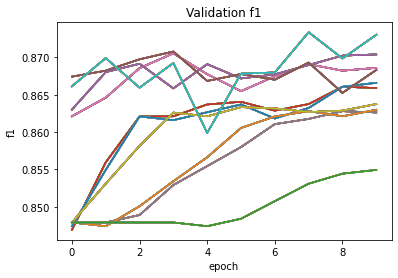

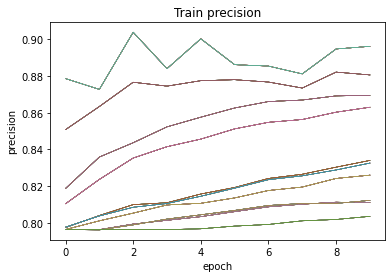

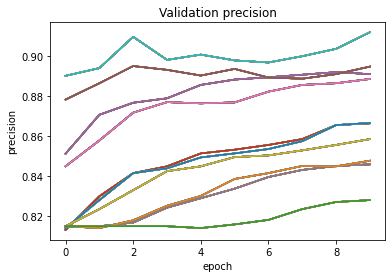

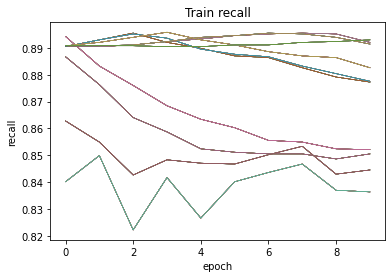

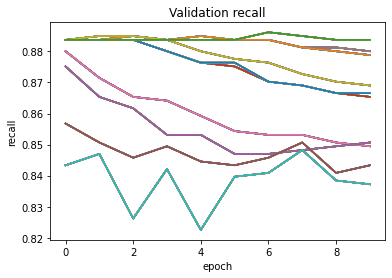

In [11]:
auto_ml = auto_ml.fit(X_train, y_train)

### Get best model and measure test accuracy

In [12]:
best_pipeline = auto_ml.get_best_model()
y_pred = best_pipeline.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Test accuracy score:", accuracy)
shutil.rmtree(tmpdir)



Test accuracy score: 0.853


### Additional note : model selection as an hyperparameter

It is possible to consider the choice of a model as a hyperparameter of its own and define an AutoML pipeline with this in mind. Consider multiple sklearn classifiers that each have their own hyperparms: 

In [13]:
classifiers: List[BaseTransformer] = [
    SKLearnWrapper(DecisionTreeClassifier(), HyperparameterSpace({
            'criterion': Choice(['gini', 'entropy']),
            'splitter': Choice(['best', 'random']),
            'min_samples_leaf': RandInt(2, 5),
            'min_samples_split': RandInt(2, 4)
        })).set_name('DecisionTreeClassifier'),
    Pipeline([
            OutputTransformerWrapper(NumpyRavel()),
            SKLearnWrapper(RidgeClassifier(), HyperparameterSpace({
                'alpha': Choice([(0.0, 1.0, 10.0), (0.0, 10.0, 100.0)]),
                'fit_intercept': Boolean(),
                'normalize': Boolean()
    }))
    ]).set_name('RidgeClassifier'),
    Pipeline([
        OutputTransformerWrapper(NumpyRavel()),
        SKLearnWrapper(LogisticRegression(), HyperparameterSpace({
            'C': LogUniform(0.01, 10.0),
            'fit_intercept': Boolean(),
            'dual': Boolean(),
            'penalty': Choice(['l1', 'l2']),
            'max_iter': RandInt(20, 200)
        }))
    ]).set_name('LogisticRegression')
]

To have an hyperparameter which decides which model to use, we recommend usage of the ChooseOneStepOf abstraction.

In [14]:
from neuraxle.steps.flow import ChooseOneStepOf

p: Pipeline = Pipeline([
    ChooseOneStepOf(classifiers)
])

If provided to an AutoML loop, a classifier will be sampled at beginning of every trial.